<a href="https://colab.research.google.com/github/amanjain487/panoptic-segmentation-using-DETR/blob/main/Visualizing_Bounding_Box_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualize Bounding Box Predictions
- To test and evaluate the results of bounding box model


## Get CUDA Device Properties

In [1]:
import time
import glob
import torch
import os

print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

PyTorch 1.11.0+cu113 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


# Mount Drive

- To load the trained model 
- To access test images.


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Install Required Libraries

In [3]:
! pip install git+https://github.com/cocodataset/panopticapi.git
! pip install pycocotools

  Cloning https://github.com/cocodataset/panopticapi.git to /tmp/pip-req-build-kduf_geq
  Running command git clone -q https://github.com/cocodataset/panopticapi.git /tmp/pip-req-build-kduf_geq
  Created wheel for panopticapi: filename=panopticapi-0.1-py3-none-any.whl size=8306 sha256=2edc04cb86f820a0457751fc78218a6cb1f37e0bd84ae6438585edca6fd4688a
  Stored in directory: /tmp/pip-ephem-wheel-cache-q4vwotxg/wheels/ad/89/b8/b66cce9246af3d71d65d72c85ab993fd28e7578e1b0ed197f1
Successfully built panopticapi


# Define CLASS NAMES, CLASS to ID Mapping, COLORS to be used, Transformations to apply

In [4]:
import torch
import torchvision.transforms as T


# These are the COCO classes
CLASSES = ['N/A', 'misc', 'textile', 'building', 'rawmaterial', 'furniture', 'floor', 'plant', 'food', 'ground', 'structural', 'water', 'wall', 'window', 'ceiling', 'sky', 'solid', 'aac_blocks', 'adhesives', 'ahus', 'aluminium_frames_for_false_ceiling', 'chiller', 'concrete_mixer_machine', 'concrete_pump', 'control_panel', 'cu_piping', 'distribution_transformer', 'dump_truck_tipper_truck', 'emulsion_paint', 'enamel_paint', 'fine_aggregate', 'fire_buckets', 'fire_extinguishers', 'glass_wool', 'grader', 'hoist', 'hollow_concrete_blocks', 'hot_mix_plant', 'hydra_crane', 'interlocked_switched_socket', 'junction_box', 'lime', 'marble', 'metal_primer', 'pipe_fittings', 'rcc_hume_pipes', 'refrigerant_gas', 'river_sand', 'rmc_batching_plant', 'rmu_units', 'sanitary_fixtures', 'skid_steer_loader', 'smoke_detectors', 'split_units', 'structural_steel_channel', 'switch_boards_and_switches', 'texture_paint', 'threaded_rod', 'transit_mixer', 'vcb_panel', 'vitrified_tiles', 'vrf_units', 'water_tank', 'wheel_loader', 'wood_primer']


# Detectron2 uses a different numbering scheme, we build a conversion table
coco2d2 = {}
count = 0
for i, c in enumerate(CLASSES):
  if c != "N/A":
    coco2d2[i] = count
    count+=1

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933],
          [0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933],
          [0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# Load Model from Drive

In [6]:
import torch
import os

os.chdir("/content/drive/MyDrive/Panoptic Segmentation using DETR/detr")

from models.backbone import Backbone, Joiner
from models.detr import DETR, PostProcess
from models.position_encoding import PositionEmbeddingSine
from models.segmentation import DETRsegm, PostProcessPanoptic
from models.transformer import Transformer

dependencies = ["torch", "torchvision"]


def _make_detr(backbone_name: str, dilation=False, num_classes=91, mask=False):
    hidden_dim = 256
    backbone = Backbone(backbone_name, train_backbone=True, return_interm_layers=mask, dilation=dilation)
    pos_enc = PositionEmbeddingSine(hidden_dim // 2, normalize=True)
    backbone_with_pos_enc = Joiner(backbone, pos_enc)
    backbone_with_pos_enc.num_channels = backbone.num_channels
    transformer = Transformer(d_model=hidden_dim, return_intermediate_dec=True)
    detr = DETR(backbone_with_pos_enc, transformer, num_classes=num_classes, num_queries=25)
    if mask:
        return DETRsegm(detr)
    return detr


os.chdir("/content/drive/MyDrive/Panoptic Segmentation using DETR/detr")
model = _make_detr("resnet50", dilation=False, num_classes=250, mask=False)
is_thing_map = {i: i >= 17 for i in range(250)}

checkpoint = torch.load("output/box_model/checkpoint0499.pth", map_location='cpu')

model.load_state_dict(checkpoint["model"])

model, postprocessor = model, PostProcessPanoptic(is_thing_map, threshold=0.85)

model.eval()

DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_f

# Define Utility Functions

In [7]:
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1) 
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

# Display Ground Truth and Predictions for 10 Random Images


/content/drive/MyDrive/Panoptic Segmentation using DETR/detr/models/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


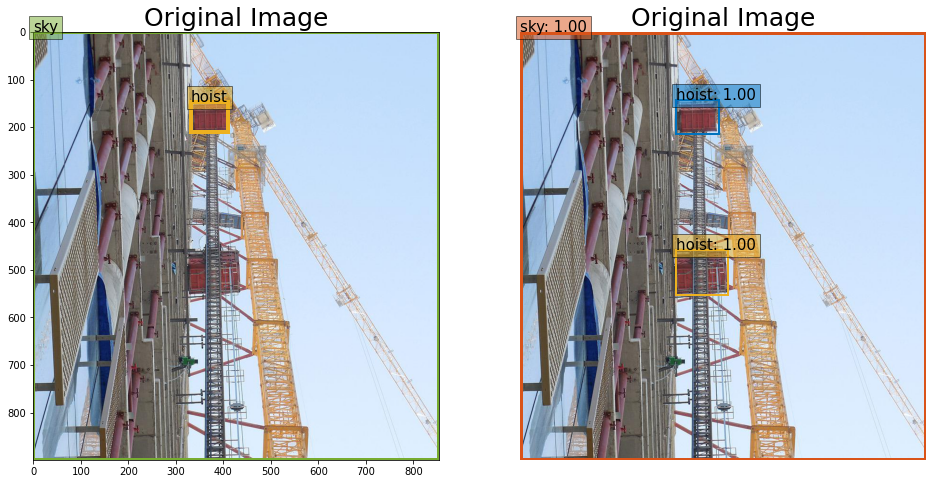

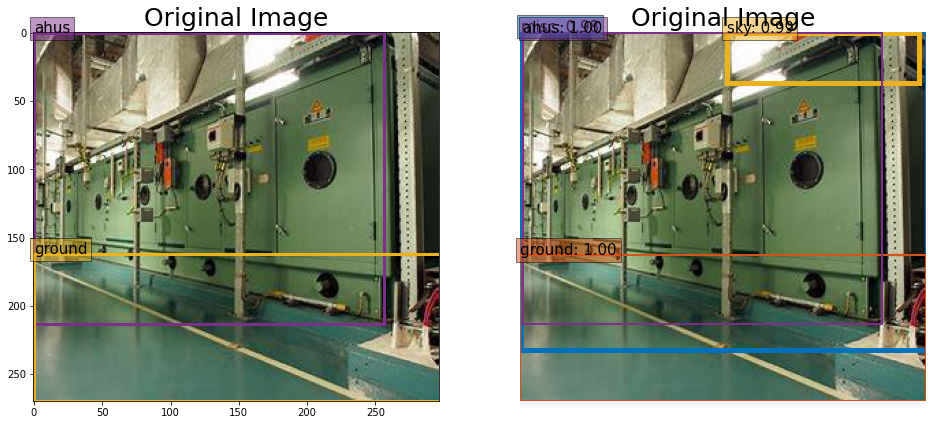

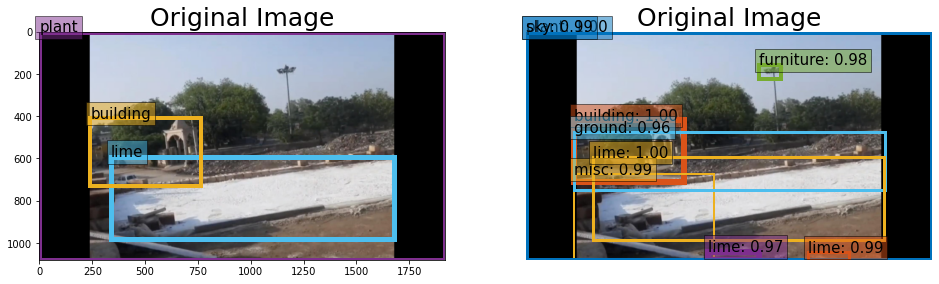

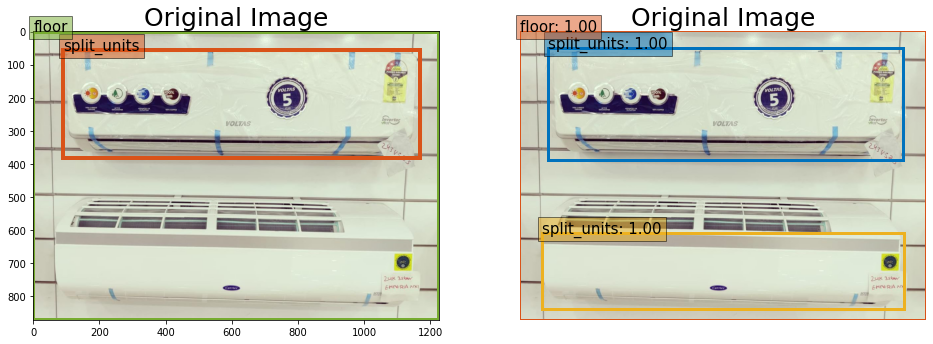

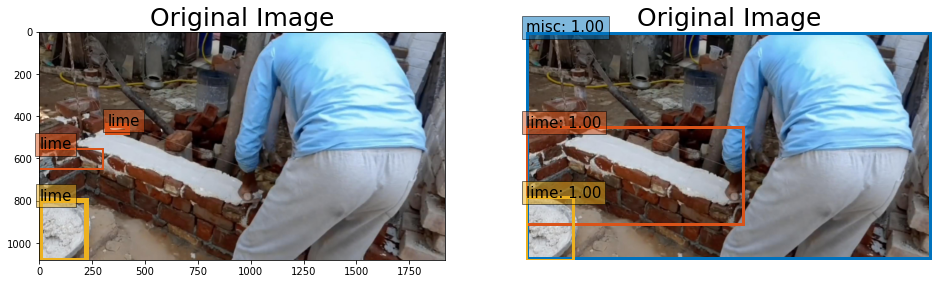

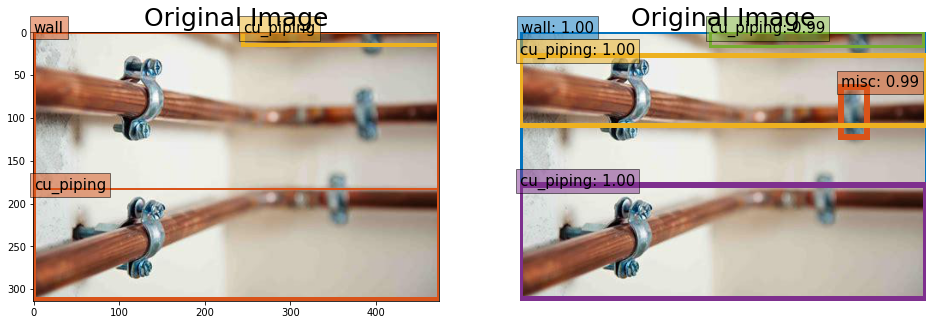

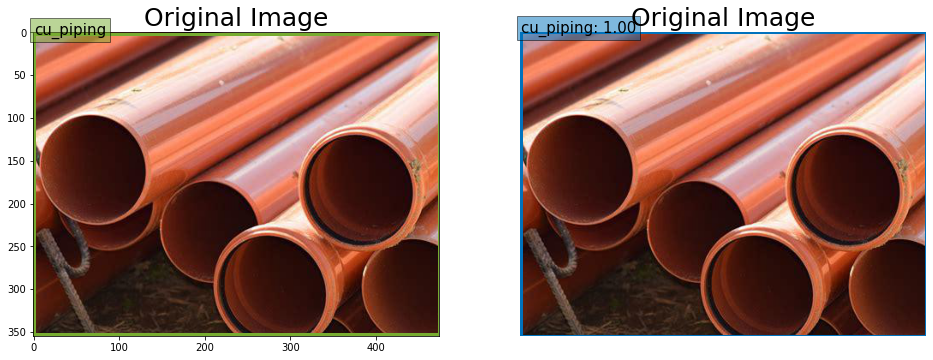

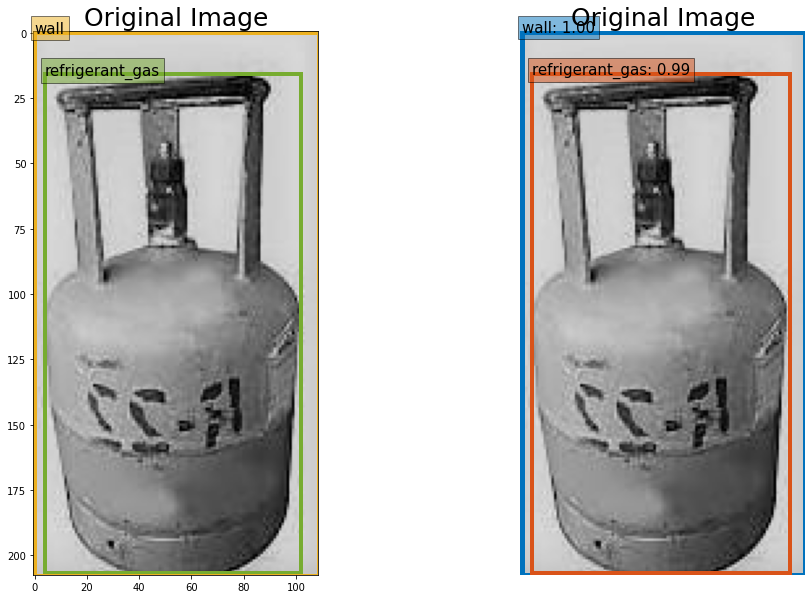

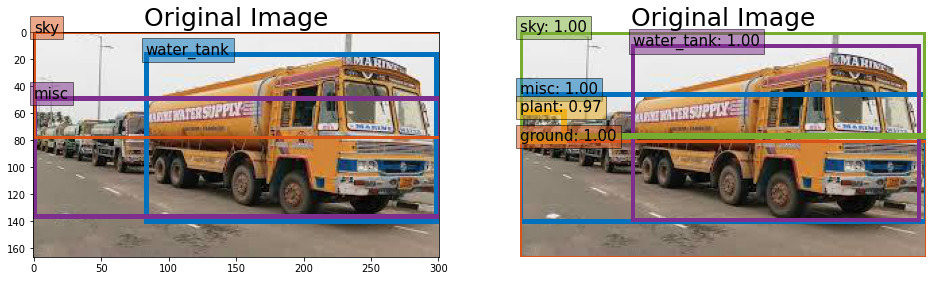

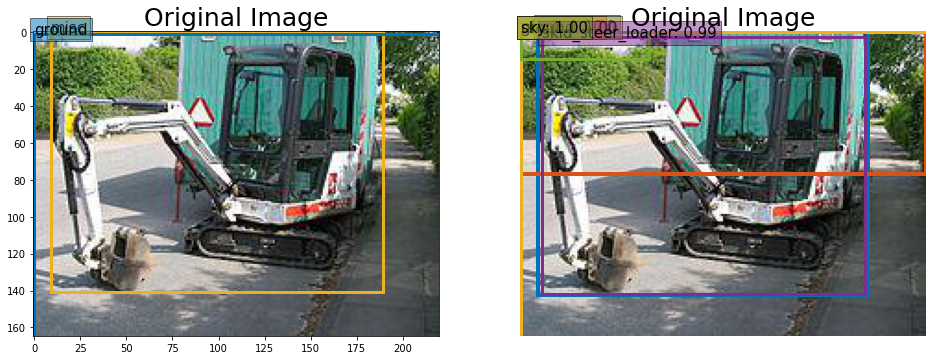

In [20]:
import torch
from PIL import Image
import os
import random
import json
import matplotlib.pyplot as plt


os.chdir("/content/drive/MyDrive/Panoptic Segmentation using DETR/data/")

val_file = open("val.json")
val_json = json.load(val_file)
val_file.close()


images = val_json["images"]

random.shuffle(images)
random.shuffle(images)
random.shuffle(images)

count = 0

os.chdir("/content/drive/MyDrive/Panoptic Segmentation using DETR/data/train")

import numpy as np
import matplotlib.pyplot as plt

w = 20
h = 20

linewidths = [2, 3, 4, 5, 6]


image_tracker = 1
for image in images:
    if count == 10:
      break
    fig = plt.figure(figsize=(16, 10))
    axes = []
    columns = 2
    rows = 1
    
    image_id = image["id"]
    img = Image.open(image["file_name"])
    axes.append( fig.add_subplot(1, 2, 1) )
    axes[-1].set_title("Original Image",  fontdict={'fontsize': 25, 'fontweight': 'medium'})  # set title

    plt.imshow(img)
    ax = plt.gca()
    colors = COLORS * 100
    for ann in val_json["annotations"]:
        if ann["image_id"] == image_id:
            random.shuffle(colors)
            c = colors[0]
            bbox = ann["bbox"]
            
            xmin, ymin, xmax, ymax = int(bbox[0]), int(bbox[1]), int(bbox[2]+bbox[0]), int(bbox[3]+bbox[1])
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=random.choice(linewidths)))
            text = f'{CLASSES[ann["category_id"]]}'
            ax.text(xmin, ymin, text, fontsize=15,
                    bbox=dict(facecolor=c, alpha=0.5))

    count += 1

    im = Image.open("/content/drive/MyDrive/Panoptic Segmentation using DETR/data/train/" + image["file_name"])

    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0)

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.85

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

    colors = COLORS * 100
    axes.append( fig.add_subplot(1, 2, 2) )
    axes[-1].set_title("Model Predictions",  fontdict={'fontsize': 25, 'fontweight': 'medium'})  # set title
    plt.imshow(im)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(probas[keep], bboxes_scaled.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=random.choice(linewidths)))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor=c, alpha=0.5))

    plt.axis('off')
    plt.show()

# Test Model Prediction for Image from Internet
- Change `img_url` in the first line of next cell



/content/drive/MyDrive/Panoptic Segmentation using DETR/detr/models/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


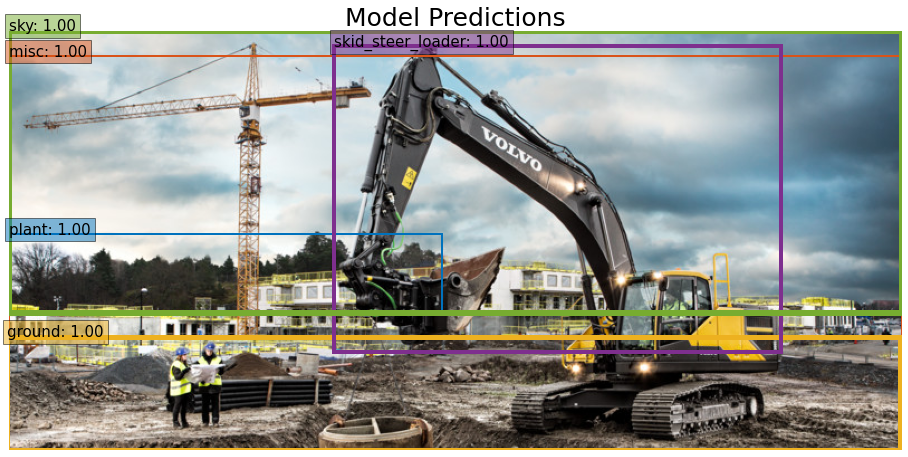

In [26]:
img_url = "https://www.goconstruct.org/media/htdbvhtw/exc_ec300e_2_001_emea_cropped_15435_citb_04_09_2022.jpg"

import requests
imageBinaryBytes = requests.get(img_url).content

import io
from PIL import Image

imageStream = io.BytesIO(imageBinaryBytes)
im = Image.open(imageStream)


fig = plt.figure(figsize=(16, 10))
axes = []
columns = 1
rows = 1

# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)

# propagate through the model
outputs = model(img)

# keep only predictions with 0.7+ confidence
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.85

# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

colors = COLORS * 100
axes.append( fig.add_subplot(1, 1, 1) )
axes[-1].set_title("Model Predictions",  fontdict={'fontsize': 25, 'fontweight': 'medium'})  # set title
plt.imshow(im)
ax = plt.gca()
for p, (xmin, ymin, xmax, ymax), c in zip(probas[keep], bboxes_scaled.tolist(), colors):
    ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                fill=False, color=c, linewidth=random.choice(linewidths)))
    cl = p.argmax()
    text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
    ax.text(xmin, ymin, text, fontsize=15,
            bbox=dict(facecolor=c, alpha=0.5))

plt.axis('off')
plt.show()
